## Семинар 7: "Методы оптимизации"

ФИО: __Господинов Георгий__

In [369]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from IPython.display import clear_output
from collections import defaultdict

%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [234]:
class GradientDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1):
        defaults = dict(lr=lr)
        super(GradientDescent, self).__init__(params, defaults)
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    g = p.grad.data
                    p.data.add_(-group['lr'] * g)

In [291]:
class Momentum(torch.optim.Optimizer):
    def __init__(self, params, gamma=0.9, lr=0.1):
        defaults = dict(lr=lr, gamma=gamma)
        super(Momentum, self).__init__(params, defaults)
        self.prev_state = {}
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    momentum = torch.zeros_like(p.data)
                    if p in self.prev_state:
                        momentum = self.prev_state[p]
                    g = p.grad.data
                    momentum *= group['gamma']
                    momentum += group['lr'] * g
                    self.prev_state[p] = momentum
                    p.data.add_(-momentum)

In [322]:
class NAG(torch.optim.Optimizer):
    def __init__(self, params, gamma=0.9, lr=0.1):
        defaults = dict(lr=lr, gamma=gamma)
        super(NAG, self).__init__(params, defaults)
        self.prev_state = {}
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    momentum = torch.zeros_like(p.data)
                    if p in self.prev_state:
                        momentum = self.prev_state[p]
                    next_p = p
                    next_p.data.add_(group['gamma'] * momentum)
                    g = next_p.grad.data
                    momentum *= group['gamma']
                    momentum += group['lr'] * g
                    self.prev_state[p] = momentum
                    p.data.add_(-momentum)

In [397]:
class Adagrad(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-1):
        defaults = dict(lr=lr, eps=eps)
        super(Adagrad, self).__init__(params, defaults)
        self.grad_history = defaultdict(list)
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    damping = np.sqrt(sum(x**2 for x in self.grad_history[p]) + group['eps'])
                    g = p.grad.data
                    self.grad_history[p].append(g)
                    p.data.add_(-group['lr'] * g / damping)

In [418]:
class Adadelta(torch.optim.Optimizer):
    def __init__(self, params, gamma=0.9, lr=0.1, eps=1e-1):
        defaults = dict(lr=lr, gamma=gamma, eps=eps)
        super(Adadelta, self).__init__(params, defaults)
        self.prev_state = {}
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    prev_grad_expect = torch.zeros_like(p.data)
                    if p in self.prev_state:
                        prev_grad_expect = self.prev_state[p]
                    g = p.grad.data
                    grad_expect = group['gamma'] * prev_grad_expect + (1 - group['gamma']) * g
                    RMS = np.sqrt(grad_expect + group['eps']) 
                    prev_RMS = np.sqrt(prev_grad_expect + group['eps']) 
                    self.prev_state[p] = grad_expect
                    p.data -= group['lr'] * prev_RMS / RMS * g

In [790]:
class Adam(torch.optim.Optimizer):
    def __init__(self, params, beta1=0.9, beta2=0.9, lr=0.1, eps=1e-1):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(Adam, self).__init__(params, defaults)
        self.prev_m = {}
        self.prev_v = {}
        self.t = 0
        
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    self.t += 1
                    prev_m = torch.zeros_like(p.data)
                    prev_v = torch.zeros_like(p.data)
                    if p in self.prev_m:
                        prev_m = self.prev_m[p]
                        prev_v = self.prev_v[p]
                    g = p.grad.data
                    m = group['beta1'] * prev_m + (1 - group['beta1']) * g
                    v = group['beta2'] * prev_v + (1 - group['beta2']) * g ** 2
                    self.prev_m[p] = m
                    self.prev_v[p] = v
                    m /= 1 - group['beta1'] ** self.t
                    v /= 1 - group['beta2'] ** self.t
                    
                    p.data -= group['lr'] / np.sqrt(v + group['eps']) * m

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [628]:
f = lambda X, Y: X**2+Y**2

In [629]:
init_point = Variable(torch.Tensor([1,2]), requires_grad=True)

In [630]:
def minimize(optimizer, init_point, func, n_epoch, clear=True):
    cur_point = init_point
    
    x = np.linspace(-6, 6, 200)
    y = np.linspace(-6, 6, 200)
    X, Y = np.meshgrid(x, y)
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    Z = func(X, Y)
    track_x = [init_point.data.numpy()[0]]
    track_y = [init_point.data.numpy()[1]]
    
    losses = []
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        loss = func(cur_point[0], cur_point[1])
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        track_x.append(cur_point.data.numpy()[0])
        track_y.append(cur_point.data.numpy()[1])
        
        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.contour(X, Y, Z)
        plt.plot(track_x, track_y, '-ro')
        plt.show()
    return losses

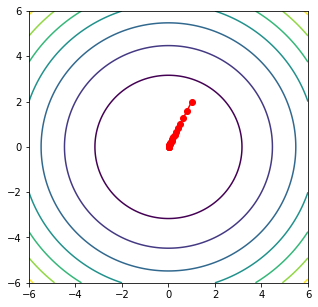

In [631]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
SGD_loss = minimize(optimizer=GradientDescent([cur_point], lr=0.1), init_point=cur_point, func=f, n_epoch=25)

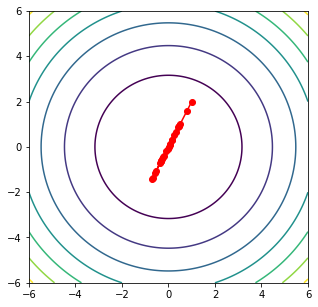

In [632]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Momentum_loss = minimize(optimizer=Momentum([cur_point], gamma=0.9, lr=0.1), init_point=cur_point, func=f, n_epoch=25)

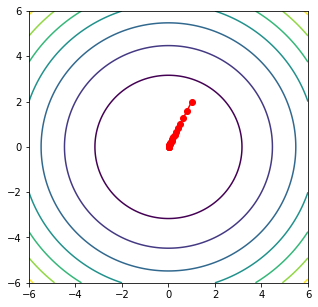

In [633]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
NAG_loss = minimize(optimizer=NAG([cur_point], gamma=0.9, lr=0.1), init_point=cur_point, func=f, n_epoch=25)

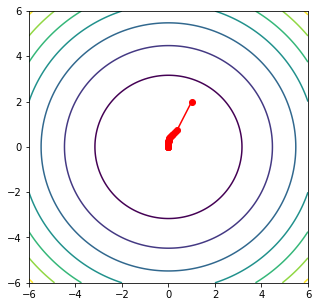

In [634]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adagrad_loss = minimize(optimizer=Adagrad([cur_point], lr=0.1, eps=1e-1), init_point=cur_point, func=f, n_epoch=25)

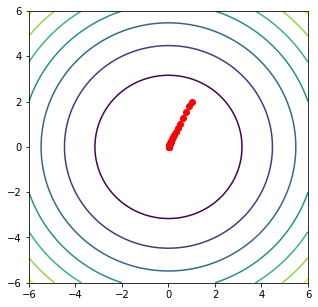

In [635]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adadelta_loss = minimize(optimizer=Adadelta([cur_point], lr=0.1, gamma=0.9, eps=1e-1), init_point=cur_point, func=f, n_epoch=25)

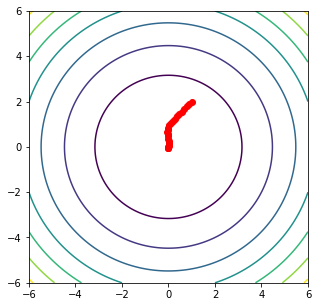

In [636]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adam_loss = minimize(optimizer=Adam([cur_point], lr=0.1, beta1=0.5, beta2=0.5, eps=1e-1), init_point=cur_point, func=f, n_epoch=25)

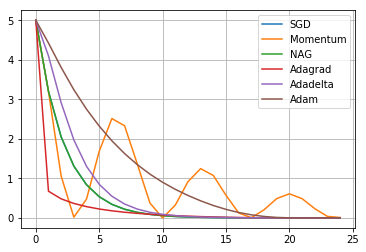

In [637]:
plt.plot(SGD_loss, label='SGD')
plt.plot(Momentum_loss, label='Momentum')
plt.plot(NAG_loss, label='NAG')
plt.plot(Adagrad_loss, label='Adagrad')
plt.plot(Adadelta_loss, label='Adadelta')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.grid()
plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [638]:
f = lambda X, Y: X**2 * torch.sin(X) + Y**2 * torch.sin(Y)

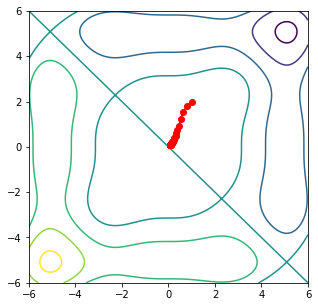

In [639]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
SGD_loss = minimize(optimizer=GradientDescent([cur_point], lr=0.1), init_point=cur_point, func=f, n_epoch=50)

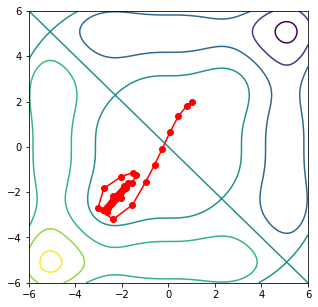

In [640]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Momentum_loss = minimize(optimizer=Momentum([cur_point], gamma=0.9, lr=0.1), init_point=cur_point, func=f, n_epoch=50)

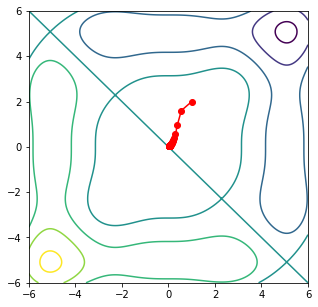

In [641]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
NAG_loss = minimize(optimizer=NAG([cur_point], gamma=1, lr=0.2), init_point=cur_point, func=f, n_epoch=50)

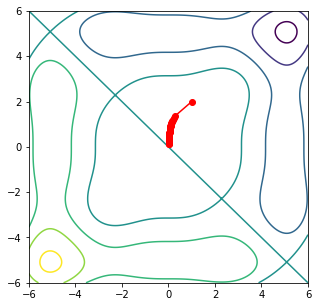

In [642]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adagrad_loss = minimize(optimizer=Adagrad([cur_point], lr=0.1, eps=1e-1), init_point=cur_point, func=f, n_epoch=50)

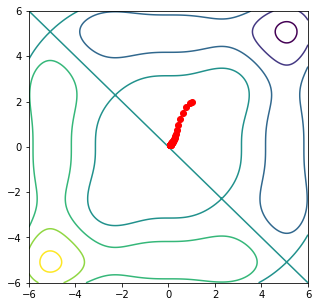

In [643]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adadelta_loss = minimize(optimizer=Adadelta([cur_point], lr=0.1, gamma=0.5, eps=1e-1), init_point=cur_point, func=f, n_epoch=50)

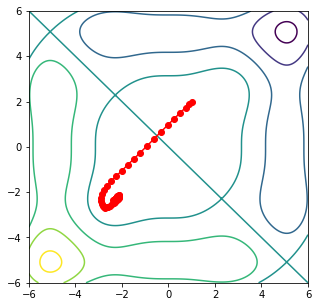

In [644]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adam_loss = minimize(optimizer=Adam([cur_point], lr=0.1, beta1=0.8, beta2=0.8, eps=1e-1), init_point=cur_point, func=f, n_epoch=50)

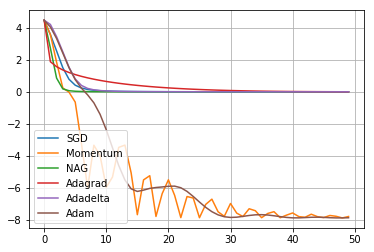

In [645]:
plt.plot(SGD_loss, label='SGD')
plt.plot(Momentum_loss, label='Momentum')
plt.plot(NAG_loss, label='NAG')
plt.plot(Adagrad_loss, label='Adagrad')
plt.plot(Adadelta_loss, label='Adadelta')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.grid()
plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [646]:
f = lambda X, Y: X**2 * torch.sin(X ** 2) + Y**2 * torch.sin(Y ** 2)

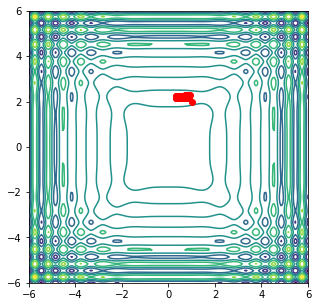

In [647]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
SGD_loss = minimize(optimizer=GradientDescent([cur_point], lr=0.02), init_point=cur_point, func=f, n_epoch=50)

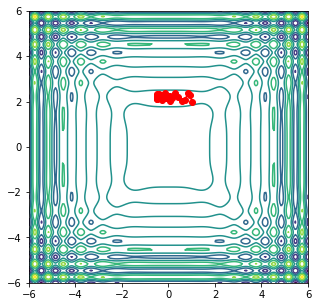

In [648]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Momentum_loss = minimize(optimizer=Momentum([cur_point], gamma=0.9, lr=0.02), init_point=cur_point, func=f, n_epoch=50)

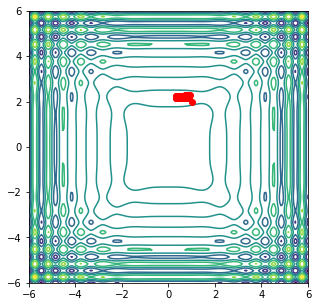

In [649]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
NAG_loss = minimize(optimizer=NAG([cur_point], gamma=0.9, lr=0.02), init_point=cur_point, func=f, n_epoch=50)

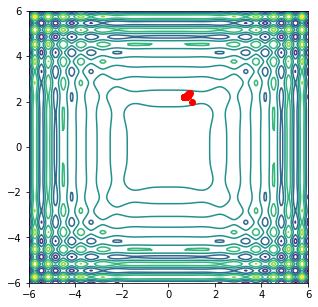

In [650]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adagrad_loss = minimize(optimizer=Adagrad([cur_point], lr=0.02, eps=0.5), init_point=cur_point, func=f, n_epoch=50)

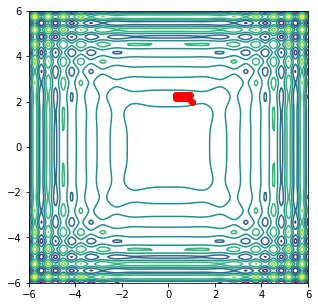

In [651]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adadelta_loss = minimize(optimizer=Adadelta([cur_point], lr=0.02, gamma=1 - 1e-4, eps=1e-2), init_point=cur_point, func=f, n_epoch=50)

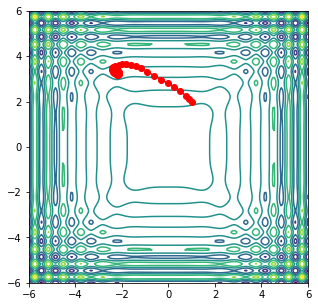

In [652]:
cur_point = Variable(init_point.data.clone(), requires_grad=True)
Adam_loss = minimize(optimizer=Adam([cur_point], lr=0.1, beta1=0.8, beta2=0.8, eps=1e-1), init_point=cur_point, func=f, n_epoch=50)

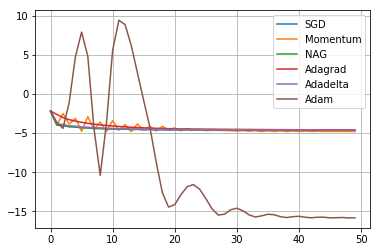

In [653]:
plt.plot(SGD_loss, label='SGD')
plt.plot(Momentum_loss, label='Momentum')
plt.plot(NAG_loss, label='NAG')
plt.plot(Adagrad_loss, label='Adagrad')
plt.plot(Adadelta_loss, label='Adadelta')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.grid()
plt.show()

In [664]:
import emoji
print(emoji.emojize('Adam :revolving_hearts:'))

Adam 💞


###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [776]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import sys

In [777]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [781]:
def train(train_loader, test_loader, network, optimizer, epochs, plot=True, verbose=True, loss=nn.NLLLoss()):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network.forward(X)
                loss_batch = loss(prediction, y)
                loss_batch.backward()
                optimizer.step()
                losses.append(loss_batch.data.numpy())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network.forward(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data.numpy())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(test_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [782]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.Sigmoid(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 14... (Train/Test) NLL: 0.023/0.083	Accuracy: 0.996/0.975

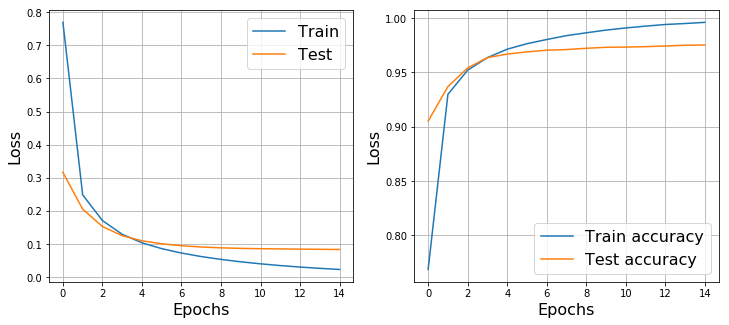

In [784]:
network = FullyConnected()
optimizer = GradientDescent(network.parameters(), lr=0.1)
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.022/0.123	Accuracy: 0.993/0.969

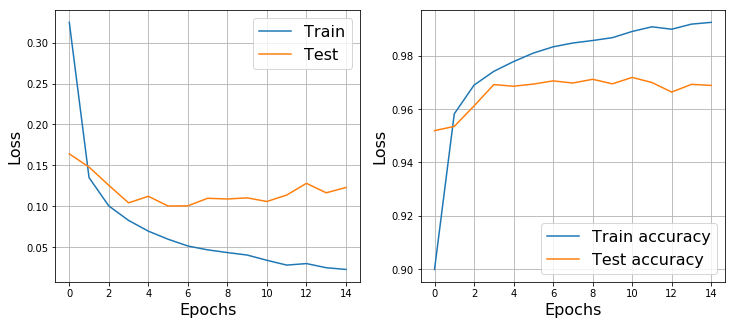

In [785]:
network = FullyConnected()
optimizer = Momentum(network.parameters(), gamma=0.9, lr=0.1)
tr_momentum, ts_momentum, tr_ac_momentum, ts_ac_momentum = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.023/0.076	Accuracy: 0.996/0.976

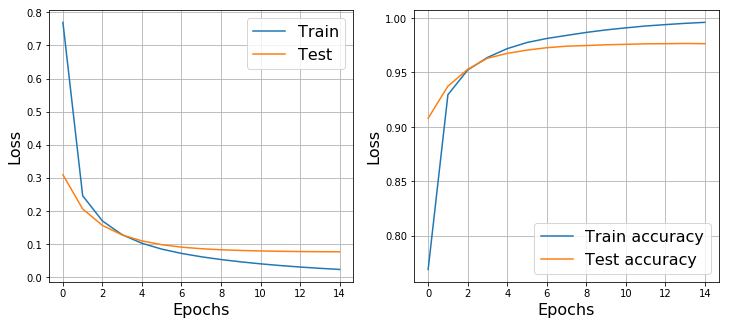

In [793]:
network = FullyConnected()
optimizer = NAG(network.parameters(), gamma=0.9, lr=0.1)
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.022/0.078	Accuracy: 0.996/0.976

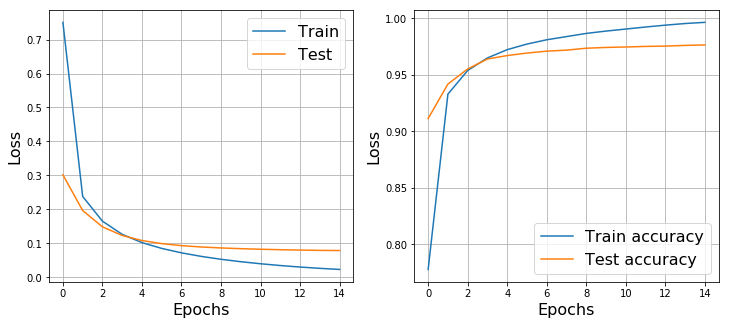

In [792]:
network = FullyConnected()
optimizer = Adadelta(network.parameters(), lr=0.1, eps=1e-1)
tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.004/0.092	Accuracy: 1.000/0.976

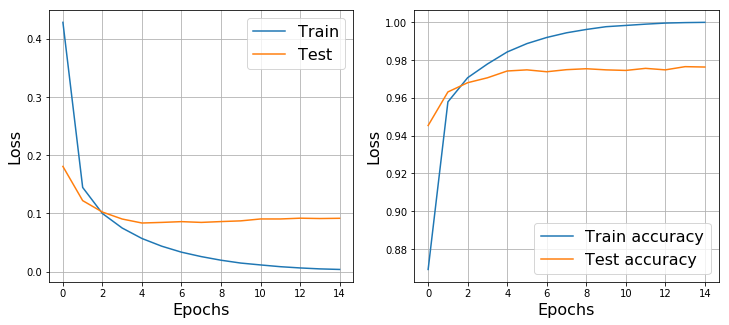

In [791]:
network = FullyConnected()
optimizer = Adam(network.parameters(), lr=0.1, eps=1e-1)
tr_adam, ts_adam, tr_ac_adam, ts_ac_adam = train(train_loader, test_loader, network, optimizer, 15)

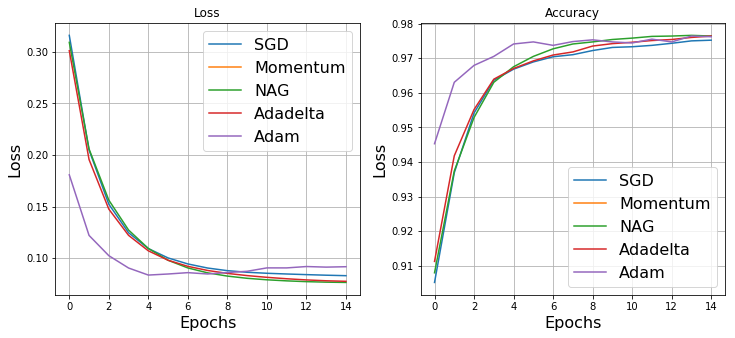

In [796]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_sgd, label='SGD')
plt.plot(ts_momentum, label='Momentum')
plt.plot(ts_nag, label='NAG')
plt.plot(ts_adadelta, label='Adadelta')
plt.plot(ts_adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_sgd, label='SGD')
plt.plot(ts_ac_momentum, label='Momentum')
plt.plot(ts_ac_nag, label='NAG')
plt.plot(ts_ac_adadelta, label='Adadelta')
plt.plot(ts_ac_adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Адам быстро минимизирует потери. Сеть начинает переобучаться

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [801]:
class Convolutional(nn.Module):
    def __init__(self, image_size=28):
        super(Convolutional, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 3, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size//2*image_size//2*3, 10),
            nn.LogSoftmax()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 14... (Train/Test) NLL: 0.065/0.113	Accuracy: 0.981/0.968

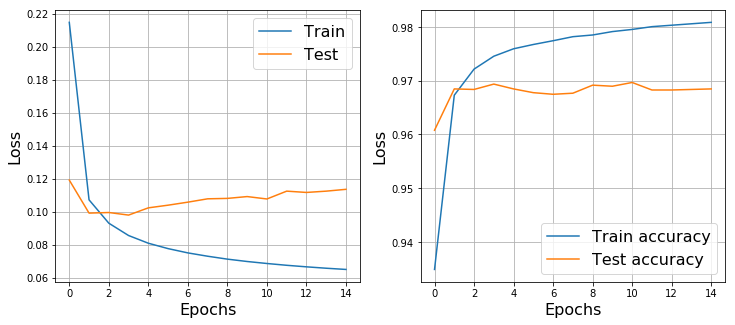

In [802]:
network = Convolutional()
optimizer = GradientDescent(network.parameters(), lr=0.1)
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.077/0.131	Accuracy: 0.977/0.963

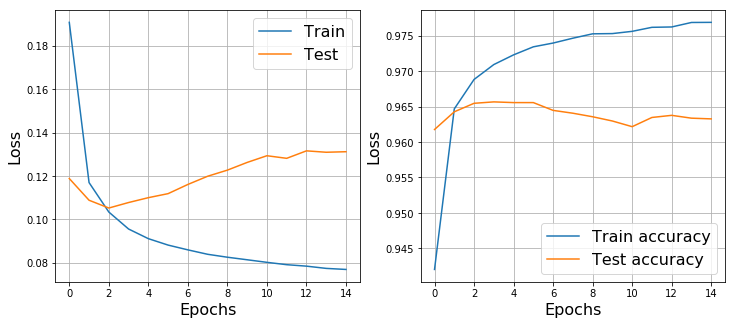

In [804]:
network = Convolutional()
optimizer = Momentum(network.parameters(), gamma=0.3, lr=0.1)
tr_momentum, ts_momentum, tr_ac_momentum, ts_ac_momentum = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.079/0.116	Accuracy: 0.976/0.967

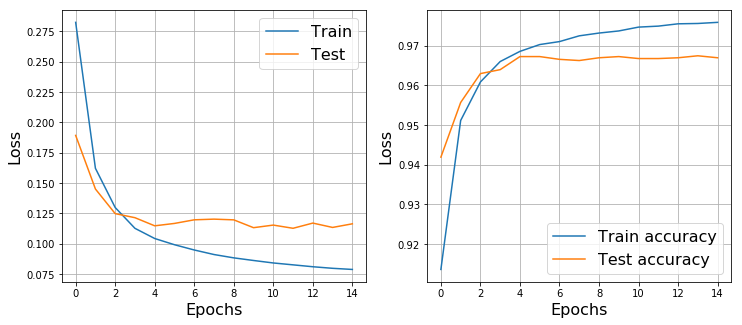

In [805]:
network = Convolutional()
optimizer = NAG(network.parameters(), gamma=0.9, lr=0.1)
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.075/0.116	Accuracy: 0.977/0.968

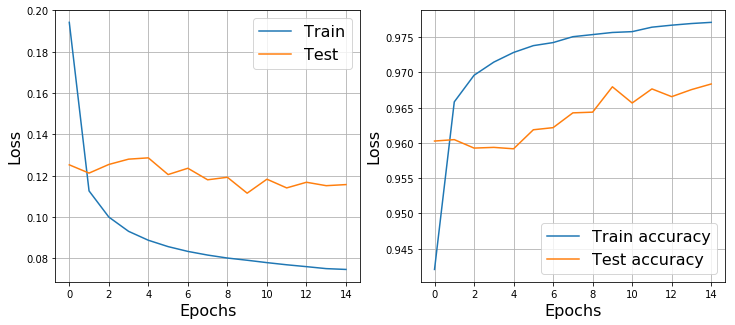

In [810]:
network = Convolutional()
optimizer = Adadelta(network.parameters(), gamma=1, lr=0.1, eps=1e-1)
tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta = train(train_loader, test_loader, network, optimizer, 15)

Epoch 14... (Train/Test) NLL: 0.125/0.245	Accuracy: 0.964/0.938

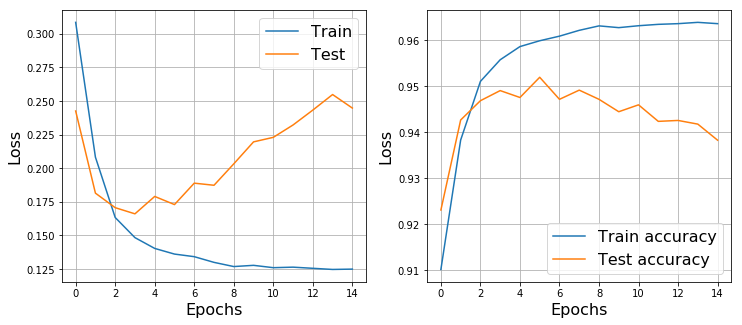

In [807]:
network = Convolutional()
optimizer = Adam(network.parameters(), lr=0.1, eps=1e-1)
tr_adam, ts_adam, tr_ac_adam, ts_ac_adam = train(train_loader, test_loader, network, optimizer, 15)

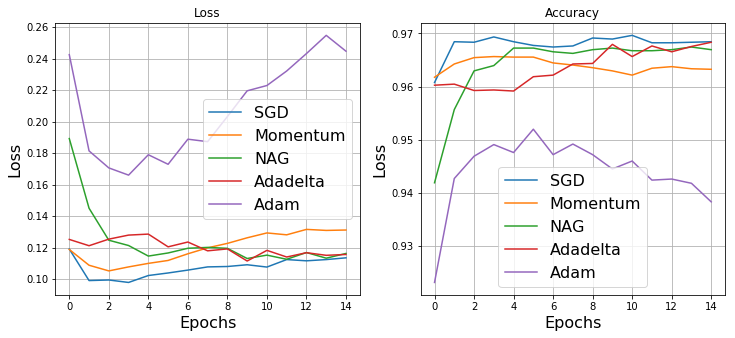

In [811]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_sgd, label='SGD')
plt.plot(ts_momentum, label='Momentum')
plt.plot(ts_nag, label='NAG')
plt.plot(ts_adadelta, label='Adadelta')
plt.plot(ts_adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_sgd, label='SGD')
plt.plot(ts_ac_momentum, label='Momentum')
plt.plot(ts_ac_nag, label='NAG')
plt.plot(ts_ac_adadelta, label='Adadelta')
plt.plot(ts_ac_adam, label='Adam')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

На простейшей сверточной архитектуре Адам показал себя хуже остальных методов: нужно тюнить гиперпараметры + добавлять дропаут. Сети сильно переобучаются

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: